In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import plotly.graph_objects as go
import plotly.express as px
import mplfinance as mpf
import scipy.stats as stats
import seaborn as sns

import warnings

# Deshabilitar todas las advertencias 
warnings.filterwarnings('ignore')

# Estilo de gráficos
plt.style.use('ggplot')

In [2]:
sp500_df = yf.download(tickers='^GSPC')[['Adj Close']]

[*********************100%%**********************]  1 of 1 completed


In [3]:
inic_per = '2000-01-01'
fin_per = '2020-12-31'

sp500_per_df = sp500_df.loc[inic_per:fin_per]
sp500_per_df.head(2)

,Adj Close
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044


Para calcular el indicador MACD (Moving Average Convergence Divergence) para el índice S&P 500, vamos a seguir estos pasos:

- Calcular la media móvil exponencial (EMA) de 12 días del precio de cierre ajustado.

- Calcular la EMA de 26 días del precio de cierre ajustado.

- Restar la EMA de 26 días de la EMA de 12 días para obtener el MACD.

- Calcular la EMA de 9 días del MACD para obtener la señal o línea de señal.

- Finalmente, podemos graficar el MACD y la línea de señal en el mismo gráfico para visualizar las intersecciones, que son las señales de compra o venta en la estrategia de trading basada en MACD.

Vamos a implementar esto paso a paso. Empezaremos por calcular el indicador MACD y graficarlo.

In [4]:
# 1. Calcular la EMA de 12 días
ema_12 = sp500_per_df['Adj Close'].ewm(span=12, adjust=False).mean()

# 2. Calcular la EMA de 26 días
ema_26 = sp500_per_df['Adj Close'].ewm(span=26, adjust=False).mean()

# 3. Calcular el MACD
sp500_per_df['MACD'] = ema_12 - ema_26

# 4. Calcular la línea de señal
sp500_per_df['Signal Line'] = sp500_per_df['MACD'].ewm(span=9, adjust=False).mean()



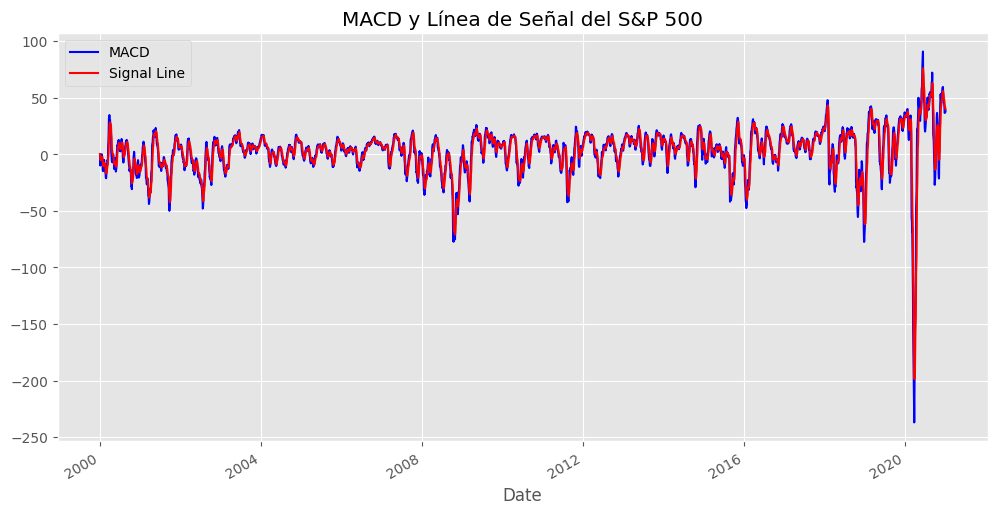

In [5]:
# Graficar el MACD y la línea de señal
plt.figure(figsize=(12,6))
sp500_per_df['MACD'].plot(label='MACD', color='blue')
sp500_per_df['Signal Line'].plot(label='Signal Line', color='red')
plt.legend(loc='upper left')
plt.title('MACD y Línea de Señal del S&P 500')
plt.show()

In [7]:
sp500_per_df.head(2)

,Adj Close,MACD,Signal Line
Date,,,
2000-01-03,1455.219971,0.000000,0.000000
2000-01-04,1399.420044,-4.451276,-0.890255


In [6]:
# Crear una figura
fig = go.Figure()

# Añadir el MACD al gráfico
fig.add_trace(go.Scatter(x=sp500_per_df.index, y=sp500_per_df['MACD'], mode='lines', name='MACD'))

# Añadir la línea de señal al gráfico
fig.add_trace(go.Scatter(x=sp500_per_df.index, y=sp500_per_df['Signal Line'], mode='lines', name='Signal Line'))

# Personalizar el layout
fig.update_layout(title='MACD y Línea de Señal del S&P 500',
                  xaxis_title='Fecha',
                  yaxis_title='Valor',
                  template="plotly_dark")

# Mostrar el gráfico
fig.show()


In [8]:
from plotly.subplots import make_subplots

In [9]:
# Crear la figura con subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                    vertical_spacing=0.1, subplot_titles=('Adjusted Close', 'MACD'),
                    row_heights=[0.5, 0.2])

# Agregar el gráfico de precios de cierre ajustados
fig.add_trace(
    go.Scatter(x=sp500_per_df.index, y=sp500_per_df['Adj Close'], name='Adj Close'),
    row=1, col=1
)

# Agregar el histograma del MACD y la línea de señal
fig.add_trace(
    go.Bar(x=sp500_per_df.index, y=sp500_per_df['MACD'] - sp500_per_df['Signal Line'], name='MACD Histogram'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=sp500_per_df.index, y=sp500_per_df['Signal Line'], name='Signal Line'),
    row=2, col=1
)

# Actualizar los títulos de los ejes y el layout
fig.update_layout(
    title_text='S&P 500 Adjusted Close and MACD',
    xaxis_title_text='Date',
    yaxis_title_text='Adjusted Close',
    xaxis2_title_text='Date',
    yaxis2_title_text='MACD',
    showlegend=False
)

# Mostrar la figura
fig.show()

La estrategia básica de trading con el MACD implica comprar (señal de compra) cuando el MACD cruza por encima de su línea de señal y vender (señal de venta) cuando el MACD cruza por debajo de su línea de señal.

A continuación, describiré cómo generar estas señales de compra y venta:

Crearemos una nueva columna llamada 'Signal' en el DataFrame.
Cuando el MACD cruza por encima de la línea de señal, pondremos un valor de "Buy" en la columna 'Signal'.
Cuando el MACD cruza por debajo de la línea de señal, pondremos un valor de "Sell" en la columna 'Signal'.

In [7]:
# Crear una columna vacía para las señales
sp500_per_df['Signal'] = ''

# Generar señales de compra y venta
for i in range(1, len(sp500_per_df)):
    # Si el MACD cruza por encima de la línea de señal, señal de compra
    if sp500_per_df['MACD'].iloc[i] > sp500_per_df['Signal Line'].iloc[i] and sp500_per_df['MACD'].iloc[i - 1] <= sp500_per_df['Signal Line'].iloc[i - 1]:
        sp500_per_df['Signal'].iloc[i] = 'Buy'
    # Si el MACD cruza por debajo de la línea de señal, señal de venta
    elif sp500_per_df['MACD'].iloc[i] < sp500_per_df['Signal Line'].iloc[i] and sp500_per_df['MACD'].iloc[i - 1] >= sp500_per_df['Signal Line'].iloc[i - 1]:
        sp500_per_df['Signal'].iloc[i] = 'Sell'

# Visualizar las señales
print(sp500_per_df[['MACD', 'Signal Line', 'Signal']].tail(10))


                 MACD  Signal Line Signal
Date                                     
2020-12-17  46.256136    49.247251       
2020-12-18  45.474276    48.492656       
2020-12-21  43.187586    47.431642       
2020-12-22  40.292806    46.003875       
2020-12-23  37.785012    44.360102       
2020-12-24  36.430647    42.774211       
2020-12-28  37.531013    41.725572       
2020-12-29  37.301710    40.840799       
2020-12-30  37.095827    40.091805       
2020-12-31  38.428703    39.759184       


In [8]:
# 1. Crear columna 'Position'
sp500_per_df['Position'] = None
for i in range(1, len(sp500_per_df)):
    # Si hay una señal de compra, estar en posición larga
    if sp500_per_df['Signal'].iloc[i] == 'Buy':
        sp500_per_df['Position'].iloc[i] = 1
    # Si hay una señal de venta, no estar en posición
    elif sp500_per_df['Signal'].iloc[i] == 'Sell':
        sp500_per_df['Position'].iloc[i] = 0
    # De lo contrario, mantener la posición anterior
    else:
        sp500_per_df['Position'].iloc[i] = sp500_per_df['Position'].iloc[i - 1]

# 2. Calcular retornos diarios
sp500_per_df['Daily Return'] = sp500_per_df['Adj Close'].pct_change()

# 3. Calcular pérdidas/ganancias
sp500_per_df['Strategy Return'] = sp500_per_df['Daily Return'] * sp500_per_df['Position'].shift(1)

# 4. Calcular beneficio total final
gross_performance = (sp500_per_df['Strategy Return'] + 1).cumprod()
final_gross_performance = gross_performance.iloc[-1]

# Imprimir beneficio total final
print(f"Beneficio total final: {final_gross_performance:.2f}")


Beneficio total final: 1.69
